In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

In [2]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,BondCH,BondUS
0,2003-09-17,5398.899902,1025.97,1.3807,3.700,5.71
1,2003-09-18,5422.600098,1039.58,1.3858,3.716,5.69


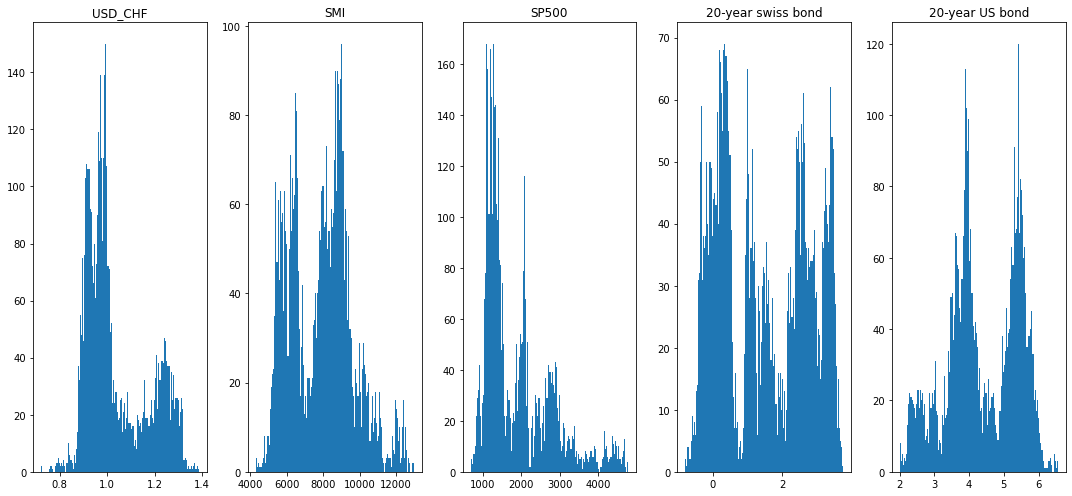

In [3]:
data = [df.USD_CHF, df.SMI, df.SP500, df.BondCH, df.BondUS]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF','SMI', 'SP500', '20-year swiss bond', '20-year US bond']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

Shape:             
X train     (3445, 7, 5), y train     (3445, 5)            
X train val (383, 7, 5) , y train val (383, 5)             
X test      (676, 7, 5) , y test      (676, 5)


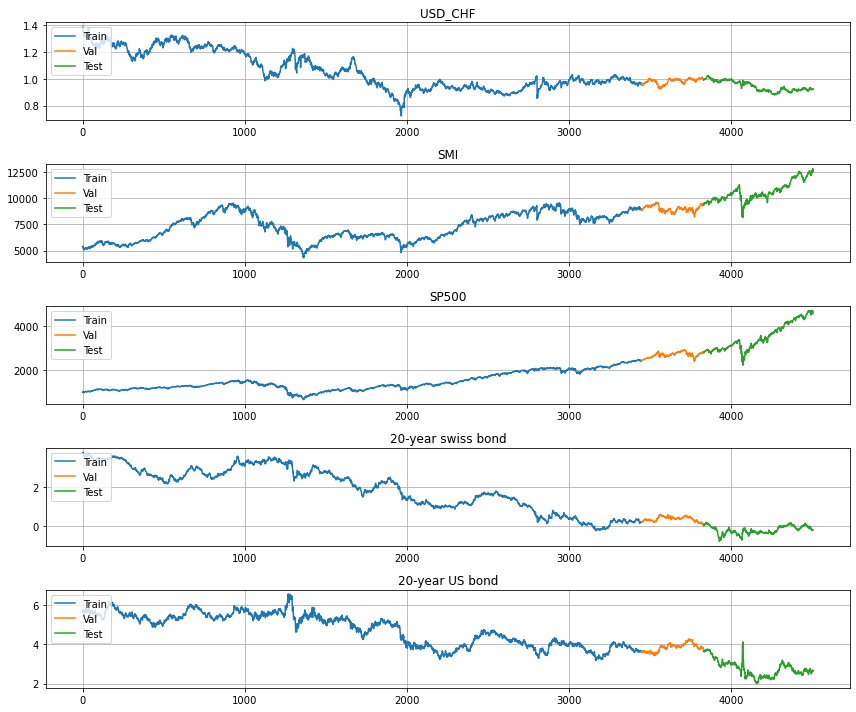

In [4]:
device = 'cpu'
LOOKBACK = 7
NORM = True
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=LOOKBACK, norm_=NORM, fraction_val_=0.1, fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Inspect some features

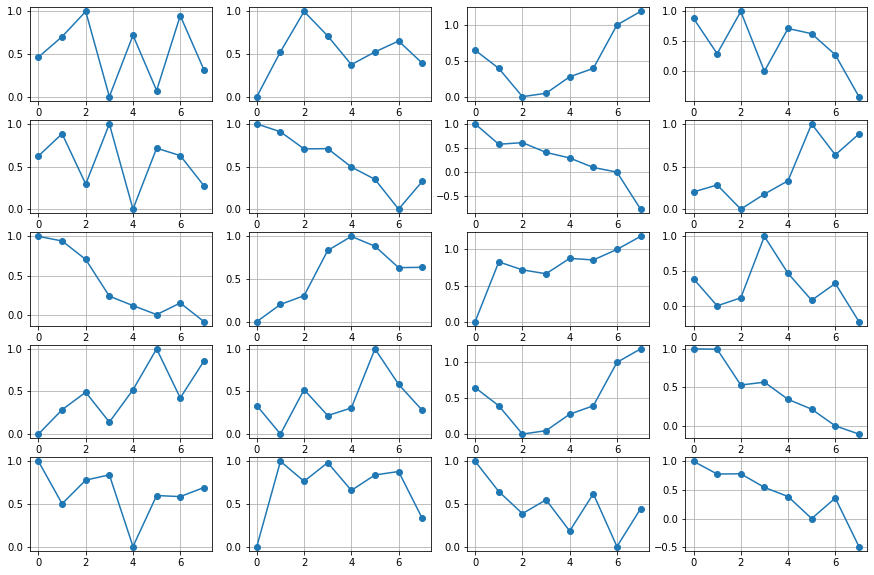

In [71]:
plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0])
        ax.plot(np.concatenate((test_x[idx,:,0], test_y[idx,0].reshape(-1,))), '-o')
        ax.grid()

plt.show()

### Auto Encoder 1-feature 

In [42]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

 21%|██        | 42/200 [00:03<00:13, 11.80it/s]

Epoch: 40/200
MSE = [train loss mean :  0.03113157] , [val loss mean:  0.03146635, MSE (last) 3.14189%]


 41%|████      | 82/200 [00:07<00:10, 11.63it/s]

Epoch: 80/200
MSE = [train loss mean :  0.03099599] , [val loss mean:  0.03138351, MSE (last) 3.13803%]


 61%|██████    | 122/200 [00:10<00:06, 11.32it/s]

Epoch: 120/200
MSE = [train loss mean :  0.03103437] , [val loss mean:  0.03132996, MSE (last) 3.12648%]


 81%|████████  | 162/200 [00:14<00:03, 11.64it/s]

Epoch: 160/200
MSE = [train loss mean :  0.03091825] , [val loss mean:  0.03126846, MSE (last) 3.12325%]


100%|██████████| 200/200 [00:17<00:00, 11.52it/s]


Epoch: 200/200
MSE = [train loss mean :  0.03090693] , [val loss mean:  0.03122619, MSE (last) 3.12133%]


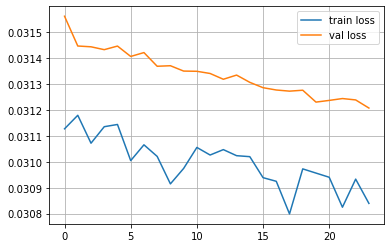

In [48]:
lr= 0.001
num_epochs= 200

train_loss, val_loss = pl.train(
    model=model_autoenc_1,
    train_x_ = train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    train_y_ =  train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_x_ = val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_y_=  val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

MSE:  0.03068


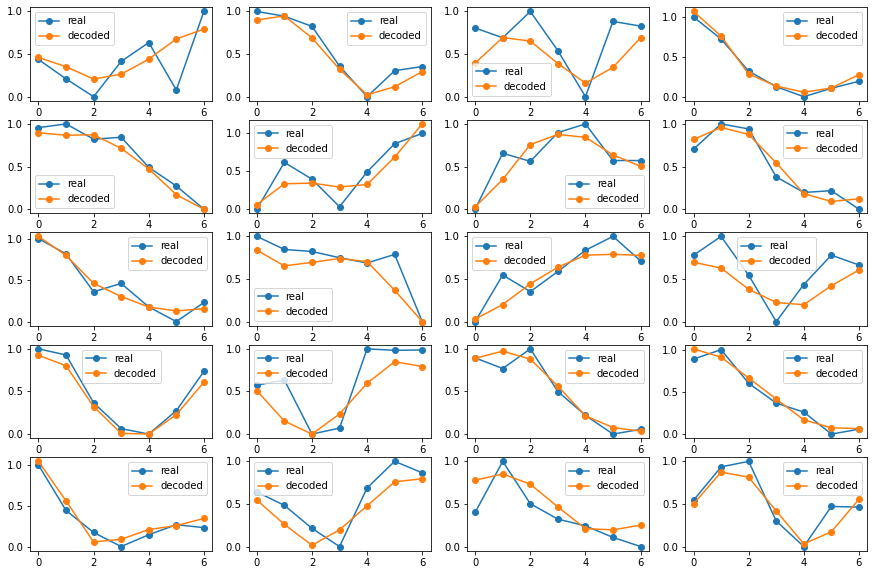

In [49]:
outputs_autoenc_1, targets, MSE = pl.evaluate(model_autoenc_1, test_x[:,:,0].reshape(-1, 1, LOOKBACK), test_x[:,:,0].reshape(-1, 1, LOOKBACK), device='cpu') 

plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0])
        ax.plot(test_x[idx,:,0], '-o', label= "real")
        ax.plot(outputs_autoenc_1[idx, 0, :], '-o', label = "decoded")
        ax.legend()
plt.show() 

In [50]:
torch.save(model_autoenc_1.cpu().state_dict(), 'Helper/model/model_autoenc_1.pth')

### Auto Encoder 5-feature 

In [51]:
model_autoenc_5 = ml.auto_encoder(
    input_size=5,
    nb_channel_conv=15
    )
model_autoenc_5.to(device)
model_autoenc_5

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(5, 15, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(15, 5, kernel_size=(3,), stride=(1,))
)

 20%|██        | 101/500 [00:16<00:57,  6.95it/s]

Epoch: 100/500
MSE = [train loss mean :  0.04489297] , [val loss mean:  0.04681002, MSE (last) 4.65290%]


 40%|████      | 201/500 [00:30<00:42,  7.00it/s]

Epoch: 200/500
MSE = [train loss mean :  0.04445758] , [val loss mean:  0.04636971, MSE (last) 4.60851%]


 60%|██████    | 301/500 [00:45<00:27,  7.11it/s]

Epoch: 300/500
MSE = [train loss mean :  0.04394139] , [val loss mean:  0.04596787, MSE (last) 4.58074%]


 80%|████████  | 401/500 [01:00<00:13,  7.07it/s]

Epoch: 400/500
MSE = [train loss mean :  0.04359978] , [val loss mean:  0.04572596, MSE (last) 4.56056%]


100%|██████████| 500/500 [01:14<00:00,  6.70it/s]

Epoch: 500/500
MSE = [train loss mean :  0.04342418] , [val loss mean:  0.04564066, MSE (last) 4.55444%]


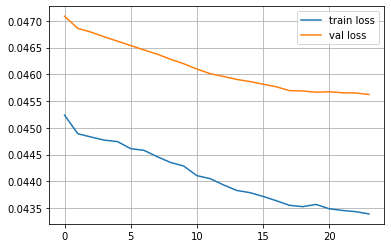

In [55]:
lr= 0.001
num_epochs= 500

train_loss, val_loss = pl.train(
    model=model_autoenc_5,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938%


MSE:  0.04550


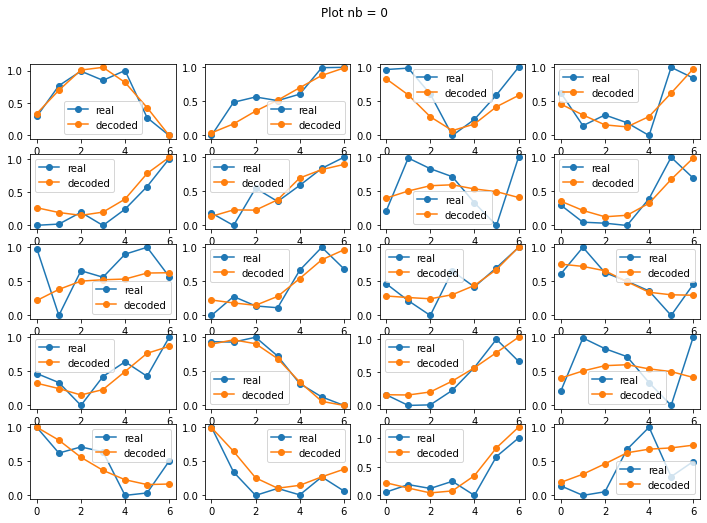

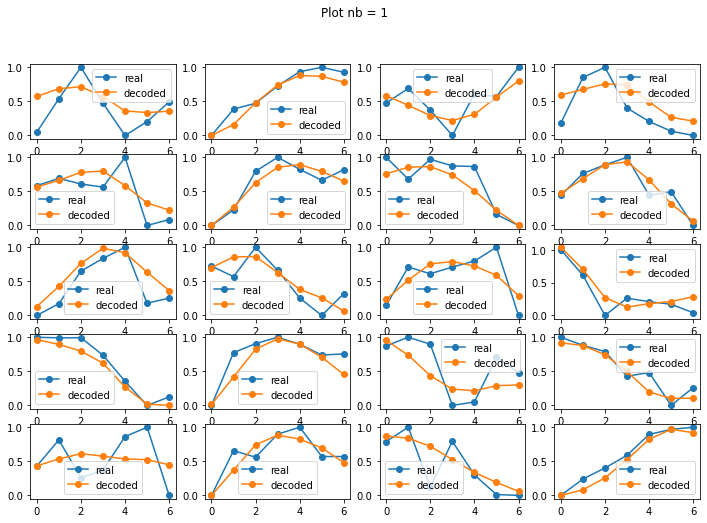

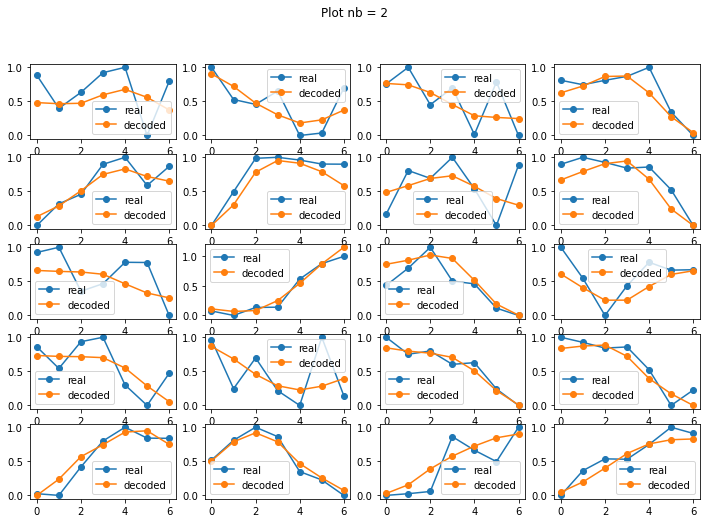

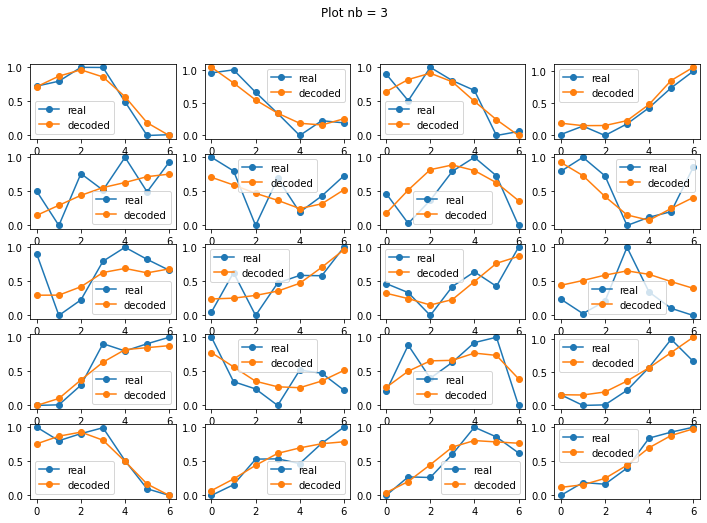

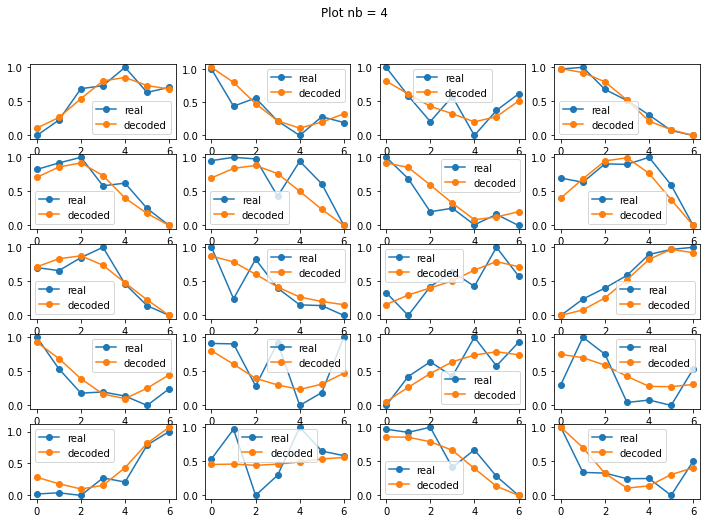

In [57]:
outputs_autoenc_5, targets, MSE = pl.evaluate(model_autoenc_5, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 

for p in range(5):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0])
            ax.plot(test_x[idx,:,0], '-o', label= "real")
            ax.plot(outputs_autoenc_5[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 

In [60]:
torch.save(model_autoenc_5.cpu().state_dict(), 'Helper/model/model_autoenc_5.pth')

# Auto encoder week 

In [65]:
df = pd.read_csv("Data/dataset_week_fin.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,CH_infl,US_infl,Shadow,BondUS,BondCH,BondCH_20,BondUS_20
0,2003-09-17,5398.899902,1025.97,1.3807,0.143,0.325027,0.86,0.958,0.18,3.700,5.71
1,2003-09-22,5257.200195,1022.82,1.3528,0.510,-0.107991,0.86,0.958,0.17,3.723,5.73


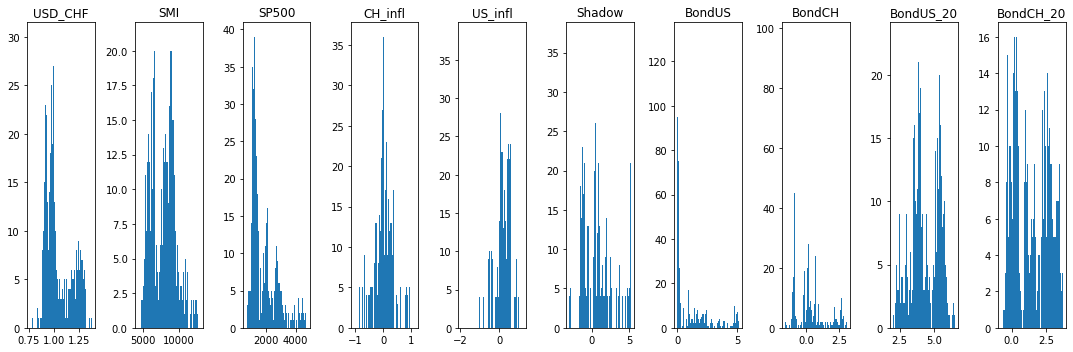

In [67]:
data = [df.USD_CHF, df.SMI, df.SP500, df.CH_infl, df.US_infl, df.Shadow, df.BondUS, df.BondCH, df.BondUS_20, df.BondCH_20]

fig = plt.figure(figsize=(15, 5))

name  = ['USD_CHF','SMI', 'SP500', 'CH_infl', 'US_infl', 'Shadow', 'BondUS', 'BondCH', 'BondUS_20', 'BondCH_20']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

16
2
12
Shape:             
X train     (724, 7, 10), y train     (724, 10)            
X train val (81, 7, 10) , y train val (81, 10)             
X test      (143, 7, 10) , y test      (143, 10)


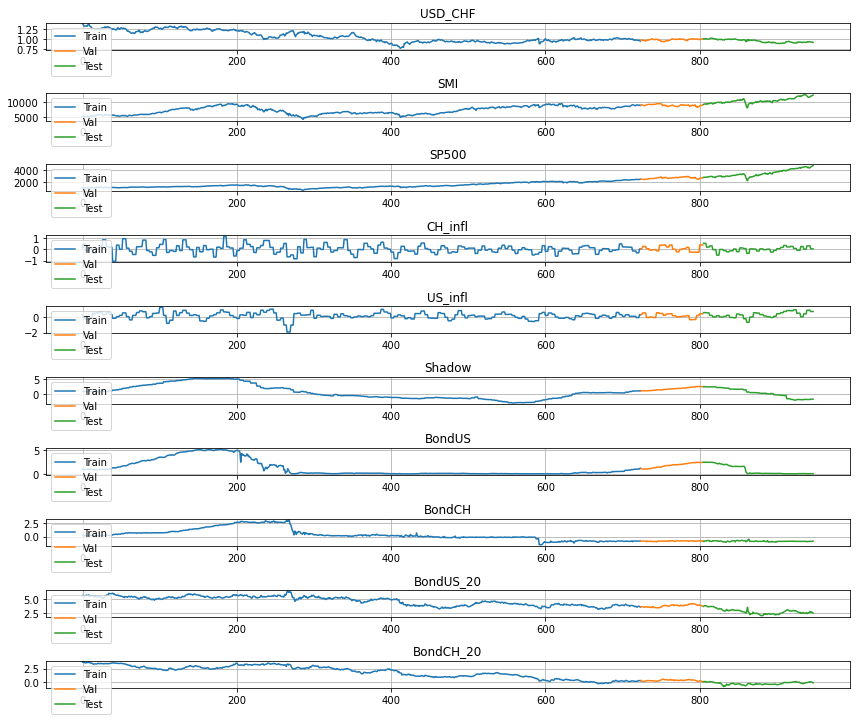

In [68]:
device = 'cpu'
LOOKBACK = 7
NORM = True
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=LOOKBACK, norm_=NORM, fraction_val_=0.1, fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [69]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] = 0.5
val_y[np.isnan(val_y)] = 0.5
test_y[np.isnan(test_y)] = 0.5 

## Inspect some features

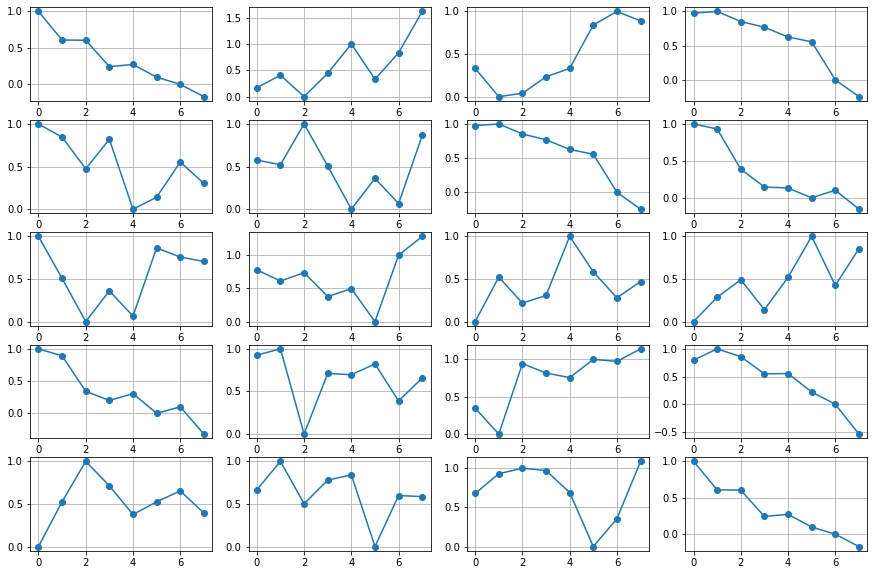

In [72]:

plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0])
        ax.plot(np.concatenate((test_x[idx,:,0], test_y[idx,0].reshape(-1,))), '-o')
        ax.grid()

plt.show()

### Auto-Encoder 1-feature 

In [117]:
model_autoenc_1_week = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1_week.to(device)
model_autoenc_1_week

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

 20%|██        | 202/1000 [00:14<01:02, 12.82it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.03126907] , [val loss mean:  0.03091089, MSE (last) 3.08366%]


 40%|████      | 402/1000 [00:26<00:35, 16.76it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.02988121] , [val loss mean:  0.02997573, MSE (last) 2.97589%]


 60%|██████    | 602/1000 [00:39<00:32, 12.23it/s]

Epoch: 600/1000
MSE = [train loss mean :  0.02954669] , [val loss mean:  0.02982980, MSE (last) 2.96092%]


 80%|████████  | 802/1000 [00:53<00:13, 14.86it/s]

Epoch: 800/1000
MSE = [train loss mean :  0.02933297] , [val loss mean:  0.02959753, MSE (last) 2.94548%]


100%|██████████| 1000/1000 [01:05<00:00, 15.18it/s]


Epoch: 1000/1000
MSE = [train loss mean :  0.02914700] , [val loss mean:  0.02942075, MSE (last) 2.91951%]


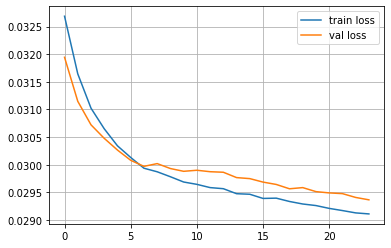

MSE:  0.04170


In [122]:
lr= 0.001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_autoenc_1_week,
    train_x_ = train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    train_y_ =  train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_x_ = val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_y_=  val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

outputs_autoenc_1, targets, MSE = pl.evaluate(model_autoenc_1_week, test_x[:,:,0].reshape(-1, 1, LOOKBACK), test_x[:,:,0].reshape(-1, 1, LOOKBACK), device='cpu') 


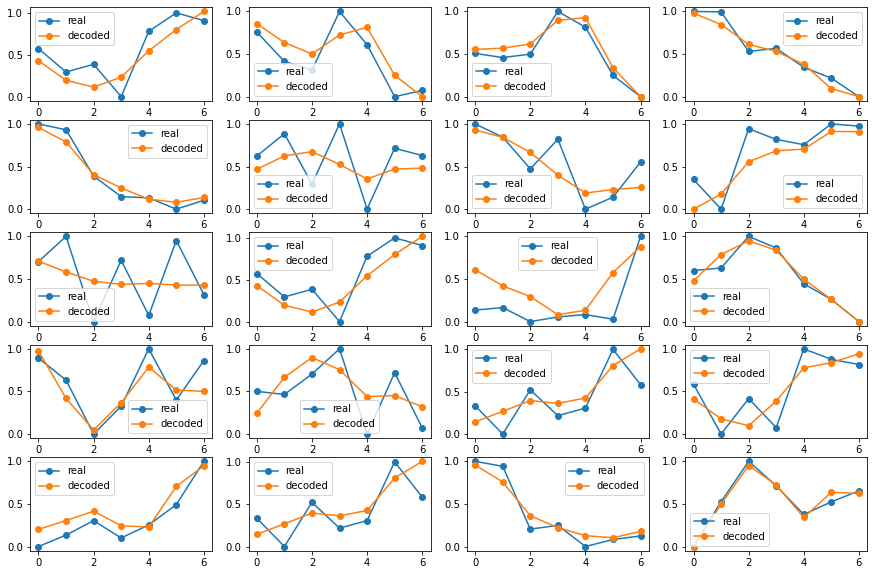

In [123]:
plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0]-1)
        ax.plot(test_x[idx,:,0], '-o', label= "real")
        ax.plot(outputs_autoenc_1[idx, 0, :], '-o', label = "decoded")
        ax.legend()
plt.show() 

In [124]:
torch.save(model_autoenc_1_week.cpu().state_dict(), 'Helper/model/model_autoenc_1_week.pth')

### Auto-Encoder 8-Features

In [125]:
model_autoenc_10_week = ml.auto_encoder(
    input_size=10,
    nb_channel_conv=30
    )
model_autoenc_10_week.to(device)
model_autoenc_10_week

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(10, 30, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(30, 10, kernel_size=(3,), stride=(1,))
)

 20%|██        | 1005/5000 [00:39<02:33, 26.05it/s]

Epoch: 1000/5000
MSE = [train loss mean :  0.04218339] , [val loss mean:  0.04633198, MSE (last) 4.57192%]


 40%|████      | 2004/5000 [01:17<01:54, 26.08it/s]

Epoch: 2000/5000
MSE = [train loss mean :  0.04152525] , [val loss mean:  0.04574083, MSE (last) 4.55948%]


 60%|██████    | 3003/5000 [01:56<01:16, 25.97it/s]

Epoch: 3000/5000
MSE = [train loss mean :  0.04113371] , [val loss mean:  0.04551908, MSE (last) 4.52501%]


 80%|████████  | 4005/5000 [02:35<00:38, 26.17it/s]

Epoch: 4000/5000
MSE = [train loss mean :  0.04008582] , [val loss mean:  0.04486601, MSE (last) 4.49491%]


100%|██████████| 5000/5000 [03:13<00:00, 25.85it/s]


Epoch: 5000/5000
MSE = [train loss mean :  0.03911717] , [val loss mean:  0.04427203, MSE (last) 4.42549%]


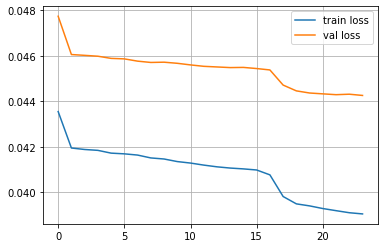

MSE:  0.05548


In [129]:
lr= 0.001
num_epochs= 5000

train_loss, val_loss = pl.train(
    model=model_autoenc_10_week,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938%


outputs_autoenc_10, targets, MSE = pl.evaluate(model_autoenc_10_week, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 



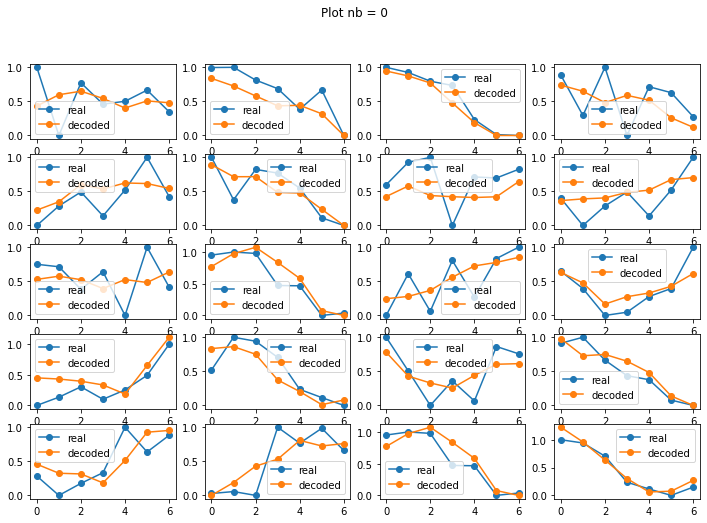

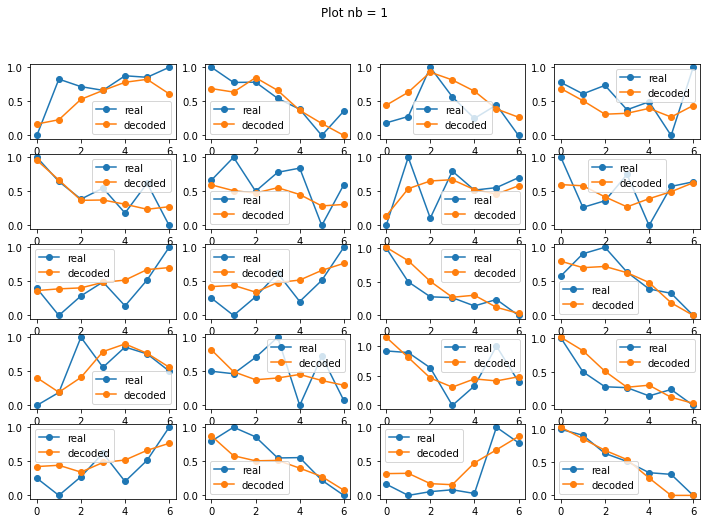

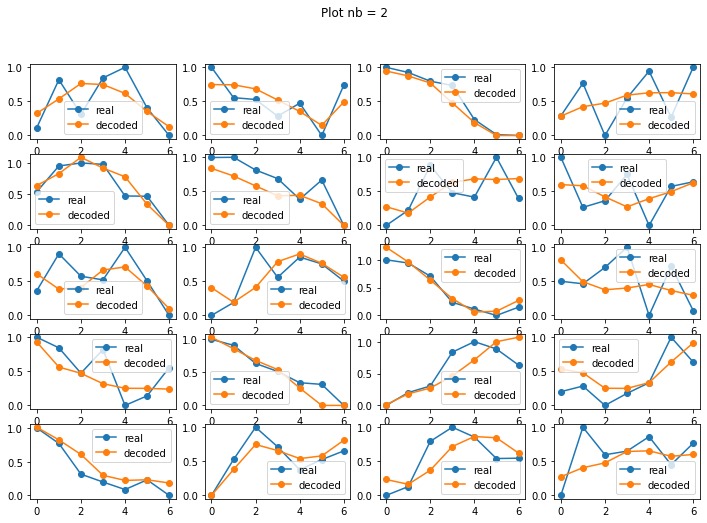

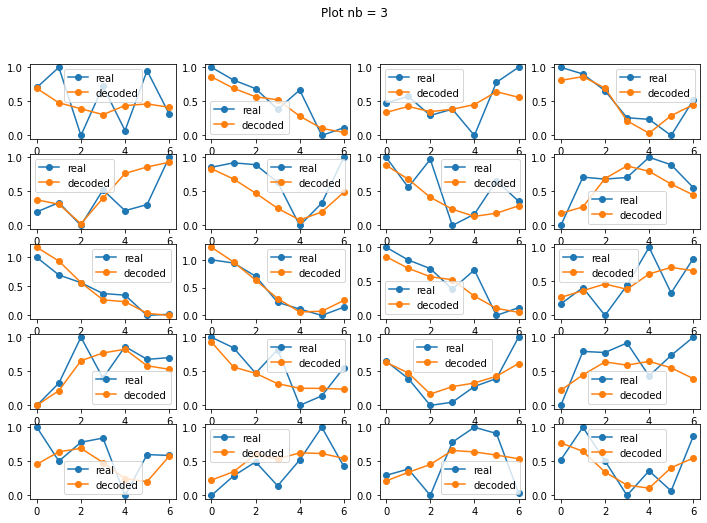

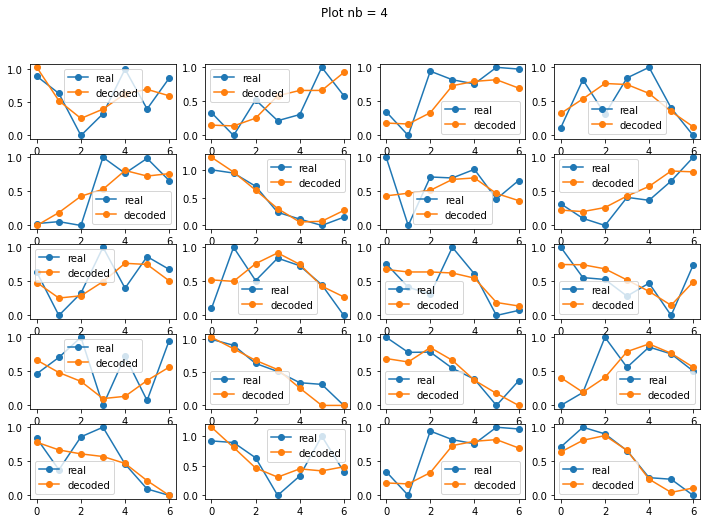

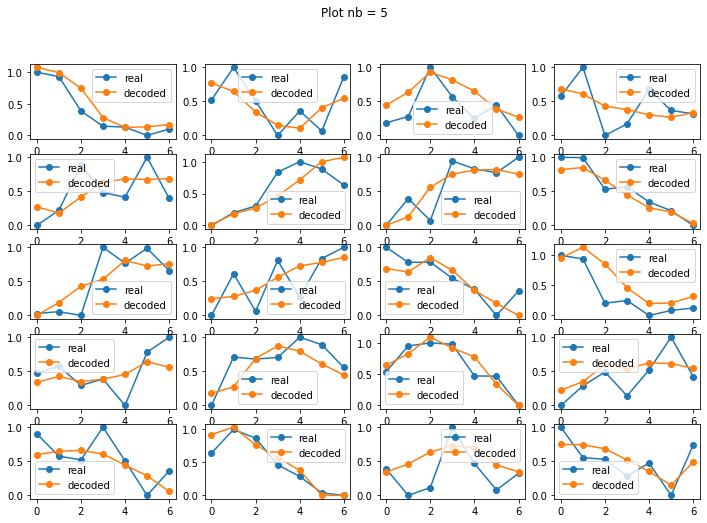

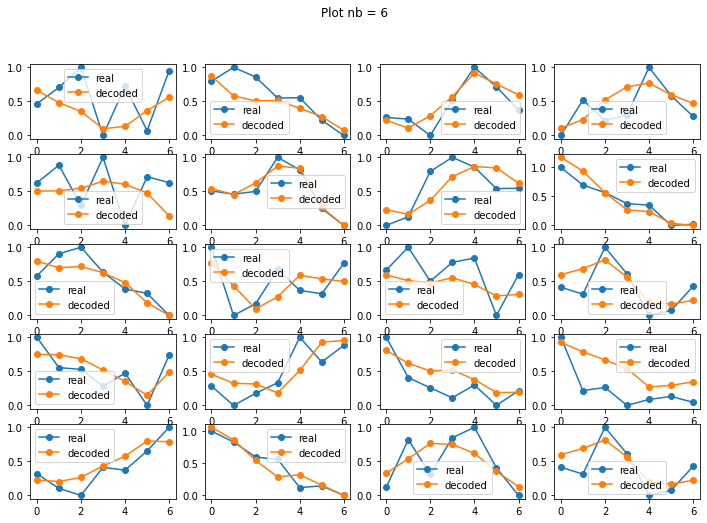

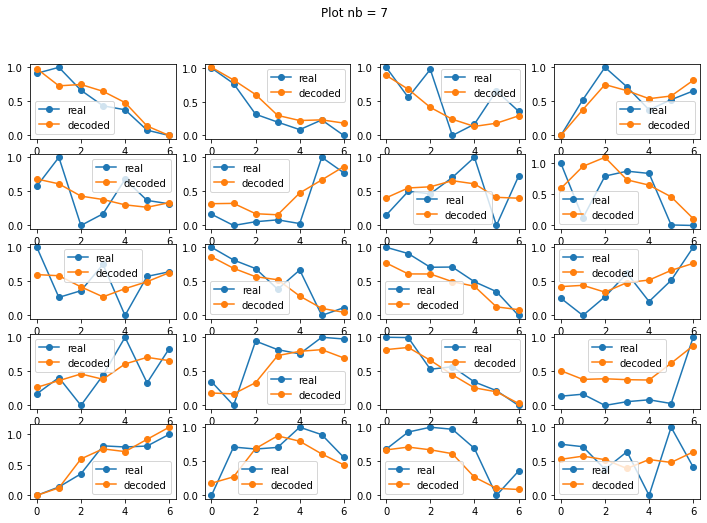

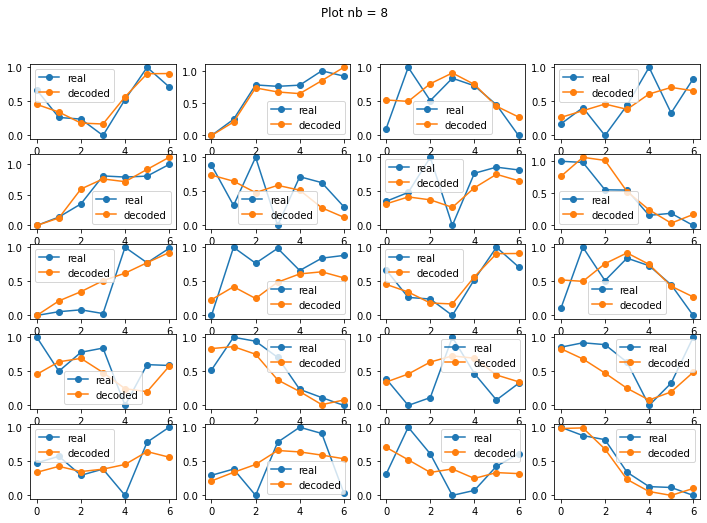

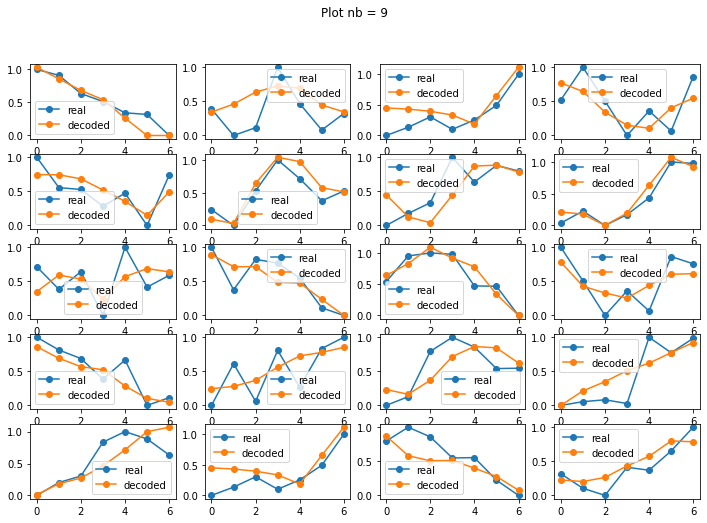

In [131]:
for p in range(10):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0]-1)
            ax.plot(test_x[idx,:,0], '-o', label= "real")
            ax.plot(outputs_autoenc_10[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 


In [133]:
torch.save(model_autoenc_10_week.cpu().state_dict(), 'Helper/model/model_autoenc_10_week.pth')